# C3DIS simulation autoencoder experiments

Plots:

- Accuracy of naive bayes on (autoencoder, deconvolving autoencoder)
- Number of training points vs accuracy for each
- Distance between peaks vs complexity score

In [47]:
import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch, torch.nn as nn, torch.optim as optim
import scipy.ndimage
from cmocean import cm
from sklearn.decomposition import PCA
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.metrics
import sklearn.linear_model
import sklearn.svm

In [2]:
class Autoencoder(nn.Module):
    loss_fn = nn.MSELoss()

    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

        # N x 1000 x 2
        self.encode = nn.Sequential(
            nn.Conv1d(2, 8, 5, padding=2),
            nn.Tanh(),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Tanh(),
        )
        
        self.linear_encode = nn.Linear(16 * 1000, n_components)
        self.linear_decode = nn.Linear(n_components, 16 * 1000)

        self.decode = nn.Sequential(
            nn.ConvTranspose1d(16, 8, 5, padding=2),
            nn.Tanh(),
            nn.ConvTranspose1d(8, 2, 5, padding=2),
            nn.Tanh(),
        )
    
    def forward(self, x):
        encoded = self.linear_encode(self.encode(x).view(-1, 16 * 1000))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, 1000))
        return recon

In [461]:
class DeconvolvingAutoencoder(nn.Module):
    loss_fn = nn.MSELoss()

    def __init__(self, rmsf, n_channels, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_channels = n_channels
        self.real_rmsf = torch.from_numpy(rmsf.real.reshape(1, 1, -1)).float()
        self.imag_rmsf = torch.from_numpy(rmsf.imag.reshape(1, 1, -1)).float()
        
        # N x 1000 x 2
        self.encode = nn.Sequential(
            nn.Conv1d(2, 8, 5, padding=2),
            nn.Tanh(),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Tanh(),
        )
        
        self.linear_encode = nn.Linear(16 * n_channels, n_components)
        self.linear_decode = nn.Linear(n_components, 16 * n_channels)

        self.decode = nn.Sequential(
            nn.ConvTranspose1d(16, 8, 5, padding=2),
            nn.Tanh(),
            nn.ConvTranspose1d(8, 2, 5, padding=2),
            nn.Tanh(),
        )

        self.deconv_1 = nn.Sequential(
            nn.Conv1d(2, 64, 3, padding=1),
            nn.Tanh(),
            nn.Conv1d(64, 16, 3, padding=1),
            nn.Tanh(),
        )
        self.linear_deconv_1 = nn.Linear(16 * n_channels, n_components)
        self.linear_deconv_2 = nn.Linear(n_components, 16 * n_channels)
        self.deconv_2 = nn.Sequential(
            nn.ConvTranspose1d(16, 64, 3, padding=1),
            nn.Tanh(),
            nn.ConvTranspose1d(64, 2, 3, padding=1),
        )
    
        self.final_activation = nn.Tanh()
    
    def conv_RMSF(self, x):
        x_real = x[:, 0, :].view((x.shape[0], 1, x.shape[2]))
        x_imag = x[:, 1, :].view((x.shape[0], 1, x.shape[2]))
        conv_real = nn.functional.conv1d(x_real, self.real_rmsf, padding=self.n_channels // 2)
        conv_imag = nn.functional.conv1d(x_imag, self.imag_rmsf, padding=self.n_channels // 2)
        return torch.cat([conv_real, conv_imag], dim=1)[:, :, :-1]
    
    def encode_dirty(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        return encoded
    
    def encode_clean(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, self.n_channels))
        deconv1 = self.linear_deconv_1(self.deconv_1(recon).view(-1, 16 * self.n_channels))
        return deconv1

    def forward(self, x):
        conv = self.conv_RMSF(x)
        encoded = self.linear_encode(self.encode(conv).view(-1, 16 * self.n_channels))
        recon = self.decode(self.linear_decode(encoded).view(-1, 16, self.n_channels))
        deconv1 = self.linear_deconv_1(self.deconv_1(recon).view(-1, 16 * self.n_channels))
        deconv = self.deconv_2(self.linear_deconv_2(deconv1).view(-1, 16, self.n_channels))
#         deconv = self.deconv(self.linear_deconv(recon.view(-1, 2 * self.n_channels)).view(-1, 16, self.n_channels))
        activ = self.final_activation(deconv)
        return conv, recon, activ
    
    @classmethod
    def loss(cls, init, conv, conv_recon, init_recon, alpha=0.5):
        loss_conv = cls.loss_fn(conv_recon, conv)
        loss_e2e = cls.loss_fn(init_recon, init)
            
        return loss_conv * alpha + (1 - alpha) * loss_e2e

In [462]:
min_phi = -1000
max_phi = 1000
phi_sampling = 300
max_noise = 0.005
n_spectra = 1000

# Generate some Faraday spectra for this epoch.

# True parameters: peak positions, amplitudes, and phases.
depths = numpy.random.randint(0, phi_sampling, size=(n_spectra, 2))
amps = numpy.random.uniform(0, 1, size=(n_spectra, 2))
simple = numpy.random.binomial(1, 0.5, size=(n_spectra,))
amps[simple, 1] = 0
phases = numpy.random.uniform(-numpy.pi, numpy.pi, size=(n_spectra, 2))
# spectra stores the real and imaginary components.
spectra = numpy.zeros((n_spectra, 2, phi_sampling))
for p in range(2):
    spectra[numpy.arange(n_spectra), 0, depths[:, p]] = amps[:, p] * numpy.cos(phases[:, p])
    spectra[numpy.arange(n_spectra), 1, depths[:, p]] = amps[:, p] * numpy.sin(phases[:, p])
# Blur this to get the "groundtruth".
spectra_blurred = scipy.ndimage.gaussian_filter1d(spectra, sigma=3, axis=-1)
# Add noise to get the input.
spectra_noisy = spectra + numpy.random.normal(scale=max_noise,
                                              size=spectra.shape)
torch_X = torch.from_numpy(spectra_noisy).float()
torch_T = torch.from_numpy(spectra_blurred).float()

In [463]:
spectra_conv = DeconvolvingAutoencoder(rmsf, phi_sampling, 64).conv_RMSF(
    torch.from_numpy(spectra_noisy).float()).numpy()

In [464]:
spectra_conv_ = spectra_conv.reshape((-1, phi_sampling * 2))

In [465]:
pca = sklearn.decomposition.PCA(n_components=64)
pca_features = pca.fit_transform(spectra_conv_)

In [466]:
phi_samp, rmsf = numpy.loadtxt('dae/rmsf.txt', dtype=complex).T
phis = numpy.linspace(min_phi, max_phi, phi_sampling)
rmsf = numpy.interp(phis, phi_samp.astype(float), rmsf)
dcae = DeconvolvingAutoencoder(rmsf, 300, 64).float()
# ae = Autoencoder(64).float()
optimiser = optim.Adagrad(dcae.parameters(), lr=1e-3)
losses = []
# %matplotlib inline
phis = phis.astype(float)
# plt.plot(phis, rmsf.real); plt.plot(phis, rmsf.imag)


dcae.load_state_dict(torch.load('/home/alger/possum/alger/dcae_2019-04-29 11-20-16.557153.model'))
dcae.eval()

/home/alger/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


DeconvolvingAutoencoder(
  (encode): Sequential(
    (0): Conv1d(2, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Tanh()
    (2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Tanh()
  )
  (linear_encode): Linear(in_features=4800, out_features=64, bias=True)
  (linear_decode): Linear(in_features=64, out_features=4800, bias=True)
  (decode): Sequential(
    (0): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Tanh()
    (2): ConvTranspose1d(8, 2, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Tanh()
  )
  (deconv_1): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Tanh()
    (2): Conv1d(64, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Tanh()
  )
  (linear_deconv_1): Linear(in_features=4800, out_features=64, bias=True)
  (linear_deconv_2): Linear(in_features=64, out_features=4800, bias=True)
  (deconv_2): Sequential(
    (0): ConvTranspose1d(16, 64, kernel_size=(3,),

# Deconvolving autoencoder

<IPython.core.display.Javascript object>


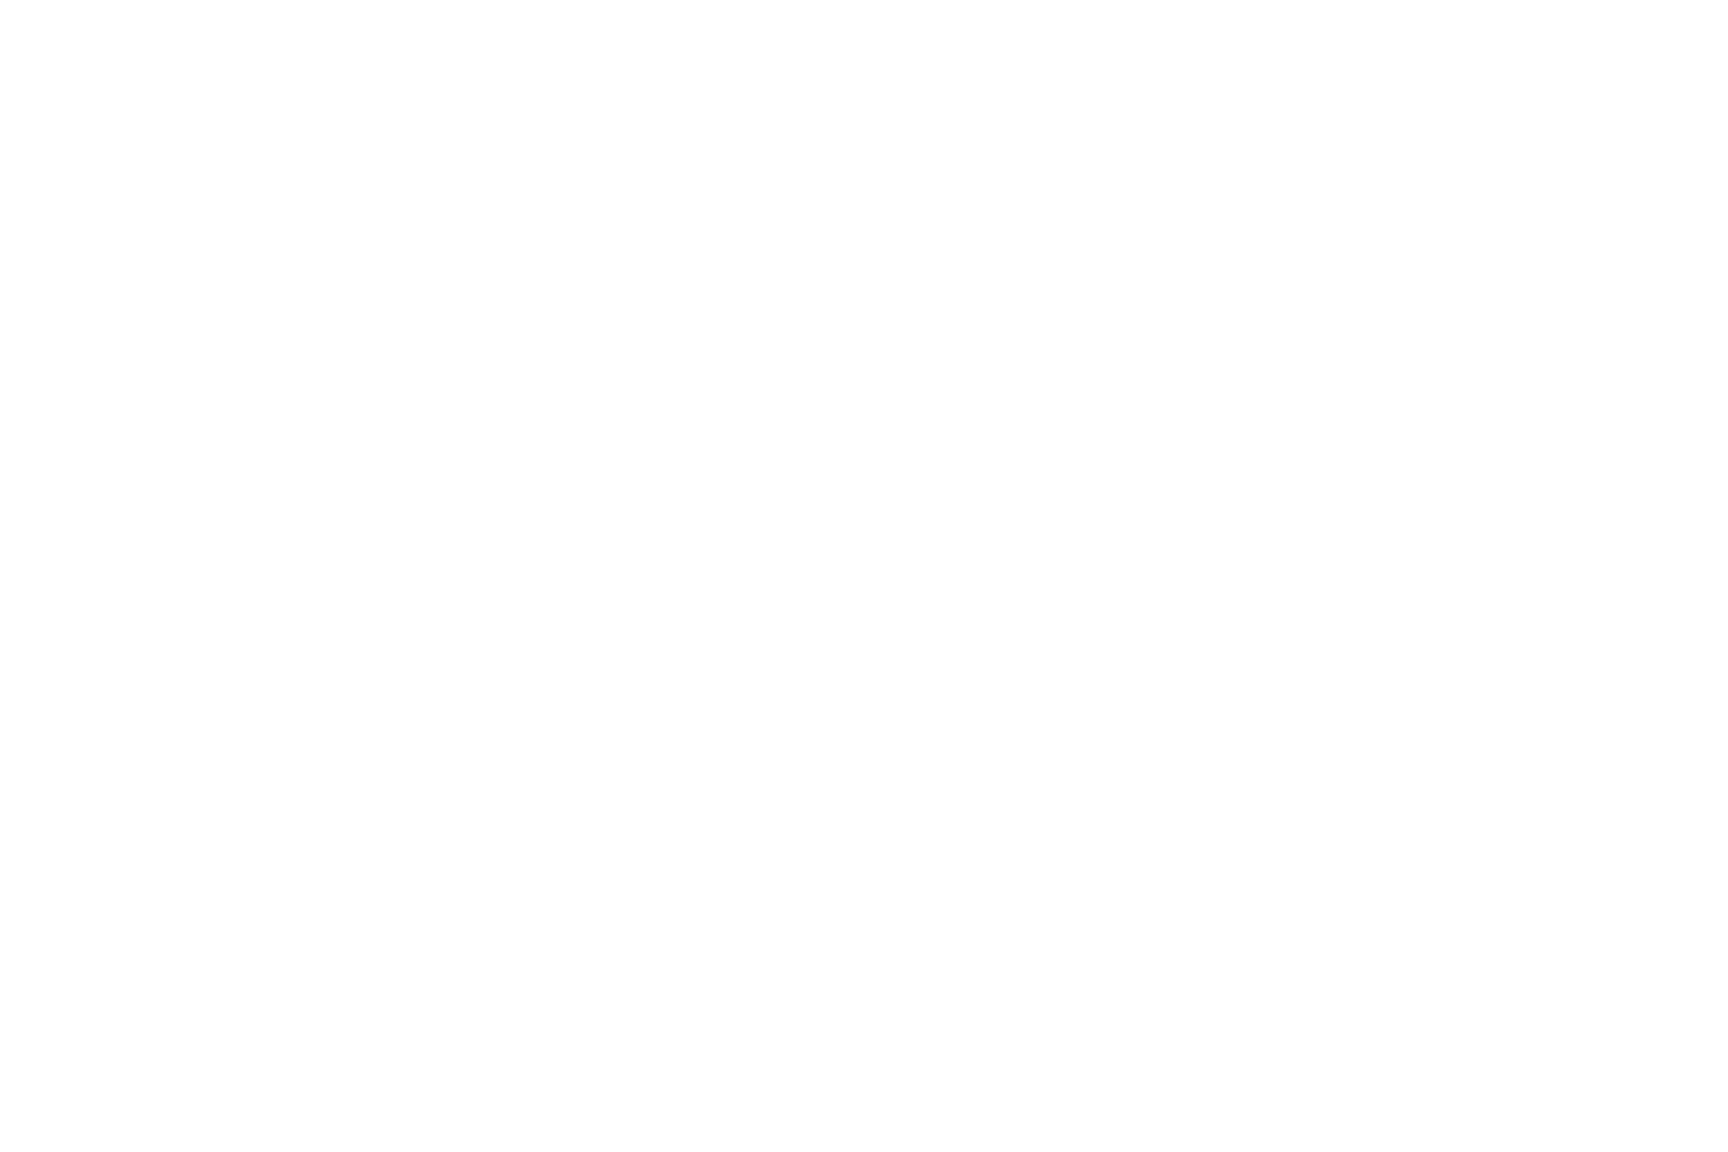

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


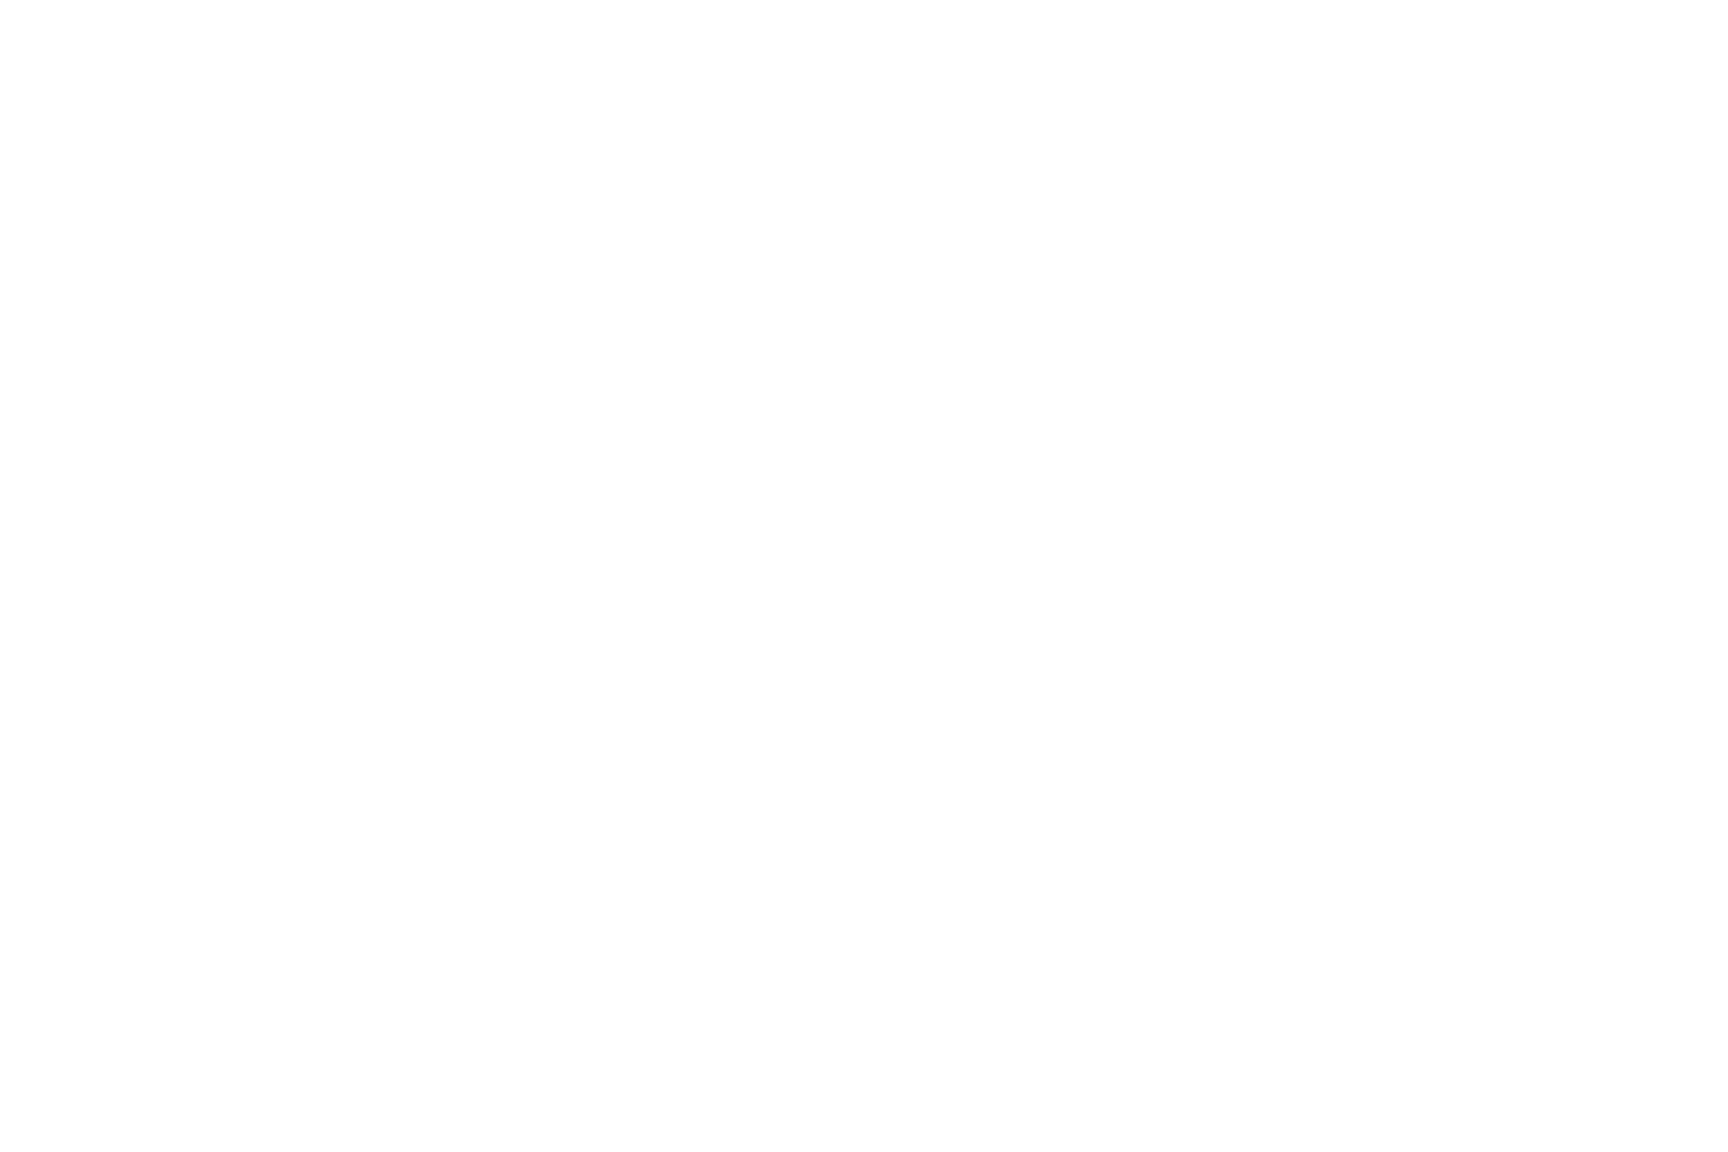

In [460]:
%matplotlib notebook
n_epochs = 1000
batch_size = 1
bar = tqdm(total=n_epochs)

fig = plt.figure(figsize=(12, 8))
ax_losses = plt.subplot2grid((2, 4), (0, 0), colspan=4)
plt_losses, = ax_losses.plot(range(len(losses)), losses)
ax_losses.set_yscale('log')
ax_init = plt.subplot2grid((2, 4), (1, 0))
ax_init.set_xlabel('$\\phi$')
ax_init.set_ylabel('$F(\\phi)$')
plt_init, = ax_init.plot(phis, phis, c='blue')
ax_conv = plt.subplot2grid((2, 4), (1, 1))
ax_conv.set_xlabel('$\\phi$')
ax_conv.set_ylabel('$F(\\phi)$')
plt_conv, = ax_conv.plot(phis, phis, c='green')
ax_recon = plt.subplot2grid((2, 4), (1, 2))
ax_recon.set_xlabel('$\\phi$')
ax_recon.set_ylabel('$F(\\phi)$')
plt_recon, = ax_recon.plot(phis, phis, c='green')
ax_deconv = plt.subplot2grid((2, 4), (1, 3))
ax_deconv.set_xlabel('$\\phi$')
ax_deconv.set_ylabel('$F(\\phi)$')
plt_deconv, = ax_deconv.plot(phis, phis, c='blue')

plt.tight_layout()

def power(spec):
    return numpy.sqrt(spec[0].detach().numpy() ** 2 + spec[1].detach().numpy() ** 2)

for e in (range(n_epochs)):
    # Train on the newly-generated spectra.
    subset = torch.randperm(len(torch_X))[:batch_size]
    torch_X_ = torch_X[subset]
    torch_T_ = torch_T[subset]

    optimiser.zero_grad()
    recons = dcae.forward(torch_X_)
    loss = dcae.loss(torch_T_, *recons, alpha=0.1)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    bar.postfix = '{:0.4e}'.format(loss.item())
    bar.update(1)

    plt_losses.set_data(range(len(losses)), losses)
    ax_losses.relim()
    ax_losses.autoscale_view()

    plt_init.set_ydata(power(torch_T_[0]))
    ax_init.relim()
    ax_init.autoscale_view()

    plt_conv.set_ydata(power(recons[0][0]))
    ax_conv.relim()
    ax_conv.autoscale_view()

    plt_recon.set_ydata(power(recons[1][0]))
    ax_recon.set_ylim(ax_conv.get_ylim())
    ax_recon.autoscale_view()

    plt_deconv.set_ydata(power(recons[2][0]))
    ax_deconv.set_ylim(ax_init.get_ylim())
    ax_deconv.autoscale_view()

    fig.canvas.draw()

In [280]:
# %matplotlib inline
# plt.plot(spectra_blurred[3].T)
# # plt.plot(spectra_noisy[3].T)

## Plots

In [469]:
recon = dcae.forward(torch_X)

In [470]:
[r.shape for r in recon]

[torch.Size([1000, 2, 300]),
 torch.Size([1000, 2, 300]),
 torch.Size([1000, 2, 300])]

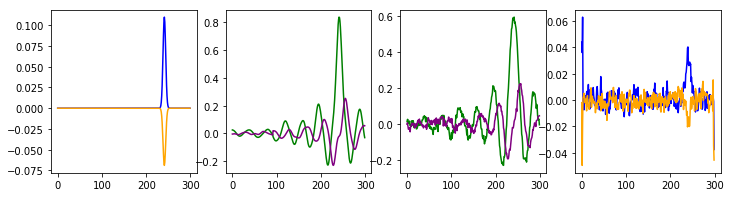

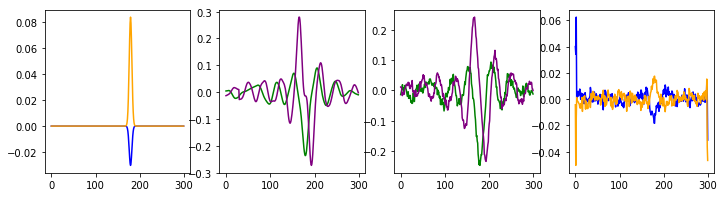

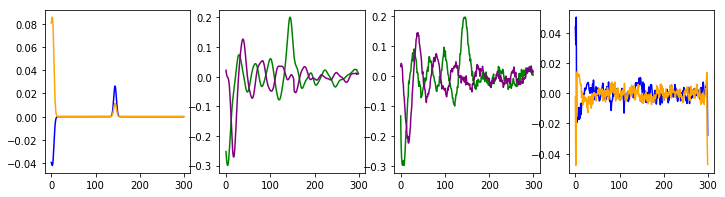

In [473]:
%matplotlib inline
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 4, 1)
    plt.plot(torch_T[i][0].detach().numpy(), c='blue')
    plt.plot(torch_T[i][1].detach().numpy(), c='orange')
    plt.subplot(1, 4, 2)
    plt.plot(recon[0][i][0].detach().numpy(), c='green')
    plt.plot(recon[0][i][1].detach().numpy(), c='purple')
    plt.subplot(1, 4, 3)
    plt.plot(recon[1][i][0].detach().numpy(), c='green')
    plt.plot(recon[1][i][1].detach().numpy(), c='purple')
    plt.subplot(1, 4, 4)
    plt.plot(recon[2][i][0].detach().numpy(), c='blue')
    plt.plot(recon[2][i][1].detach().numpy(), c='orange')
    plt.show()

## Testing the deconvolving autoencoder

In [478]:
labels = simple * 2 - 1
labels[:10]
encoding_dirty = dcae.encode_dirty(torch_X).detach().numpy()
encoding_clean = dcae.encode_clean(torch_X).detach().numpy()

In [485]:
encoding_recon = dcae.forward(torch_X)[-1].detach().numpy()

In [492]:
encoding_recon = encoding_recon.reshape((encoding_recon.shape[0], -1))

In [479]:
def test_extracted_features(features, labels):
    train_X, test_X, train_Y, test_Y = sklearn.model_selection.train_test_split(
        features, labels, test_size=0.2, shuffle=True, stratify=labels)
    train_X, val_X, train_Y, val_Y = sklearn.model_selection.train_test_split(
        train_X, train_Y, test_size=0.2, shuffle=True, stratify=train_Y)

    clf_dcae = sklearn.svm.OneClassSVM()
    param_dist = {"gamma": scipy.stats.expon(scale=0.1),
                  "nu": scipy.stats.uniform(loc=0, scale=1)}
    n_iter_search = 200
    random_search = sklearn.model_selection.RandomizedSearchCV(
        clf_dcae, param_distributions=param_dist,
        n_iter=n_iter_search, cv=sklearn.model_selection.ShuffleSplit(n_splits=1, test_size=0.0), iid=False,
        scoring=lambda clf, data: sklearn.metrics.accuracy_score(val_Y, clf.predict(val_X)))
    random_search.fit(train_X[train_Y == 1])
    
    return {
        'cm_train': sklearn.metrics.confusion_matrix(train_Y, random_search.predict(train_X)),
        'cm_test': sklearn.metrics.confusion_matrix(test_Y, random_search.predict(test_X)),
        'acc_train': sklearn.metrics.accuracy_score(train_Y, random_search.predict(train_X)),
        'acc_test': sklearn.metrics.accuracy_score(test_Y, random_search.predict(test_X)),
    }

In [480]:
test_extracted_features(encoding_dirty, labels)

{'cm_train': array([[ 80, 223],
        [ 52, 285]]), 'cm_test': array([[30, 65],
        [23, 82]]), 'acc_train': 0.5703125, 'acc_test': 0.56}

In [481]:
test_extracted_features(encoding_clean, labels)

{'cm_train': array([[117, 186],
        [121, 216]]), 'cm_test': array([[44, 51],
        [34, 71]]), 'acc_train': 0.5203125, 'acc_test': 0.575}

In [487]:
test_extracted_features(encoding_recon, labels)

{'cm_train': array([[111, 192],
        [110, 227]]), 'cm_test': array([[26, 69],
        [25, 80]]), 'acc_train': 0.528125, 'acc_test': 0.53}

In [482]:
test_extracted_features(pca_features, labels)

{'cm_train': array([[ 79, 224],
        [ 94, 243]]), 'cm_test': array([[22, 73],
        [23, 82]]), 'acc_train': 0.503125, 'acc_test': 0.52}

In [483]:
test_extracted_features(spectra_conv_, labels)

{'cm_train': array([[111, 192],
        [130, 207]]), 'cm_test': array([[39, 56],
        [28, 77]]), 'acc_train': 0.496875, 'acc_test': 0.58}

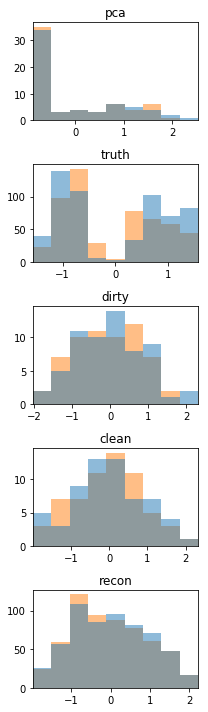

In [504]:
plt.figure(figsize=(3, 10))
for i, name, features in zip(
        range(1, 6),
        ['pca', 'truth', 'dirty', 'clean', 'recon'],
        [pca_features, spectra_conv_, encoding_dirty, encoding_clean, encoding_recon]):
    mean_pos = features[labels > 0].std(axis=0)
    mean_neg = features[labels < 0].std(axis=0)
    mean_pos -= mean_pos.mean()
    mean_pos /= mean_pos.std()
    mean_neg -= mean_neg.mean()
    mean_neg /= mean_neg.std()
    plt.subplot(5, 1, i)
    lim = (numpy.percentile(mean_pos, 1), numpy.percentile(mean_pos, 99))
    plt.hist([mean_pos, mean_neg], histtype='stepfilled', bins=numpy.linspace(*lim, 10), alpha=0.5)
    plt.xlim(lim)
    plt.title(name)
plt.tight_layout()